In [415]:
import pandas as pds
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from tabulate import tabulate
from pandasql import sqldf
import functools

## define function for printing pandas dataframes as markdown

In [2]:
def print_pandas_md(df):
    print(tabulate(df, tablefmt="pipe", headers="keys"))

## define function to round values in an interval object

In [3]:
def round_interval(interval):
    left_val = round(interval.left)
    right_val = round(interval.right)
    return pds.Interval(left=left_val, right=right_val, closed='left')

## helper fuction for showing values on bars
adapted from: https://stackoverflow.com/questions/43214978/seaborn-barplot-displaying-values

In [291]:
def show_values_on_bars(axs, h_v="v", horizontal_space=5, vertical_space=5, ha="center", va="bottom", fontsize=12):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + float(vertical_space)
                # print(p.get_height())
                value = int(p.get_height())
                value = f"{value:,}" # add comma to value
                ax.text(_x, _y, value, ha=ha, va=va, fontsize=fontsize) 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(horizontal_space)
                # print(p.get_width())
                _y = p.get_y() + p.get_height() / 2
                value = int(p.get_width())
                value = f"{value:,}" # add comma to value
                ax.text(_x, _y, value, ha=ha, va=va, fontsize=fontsize)

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

## load local copies of data

In [5]:
patient_df = pds.read_csv('triplestore-patient-info.tsv', sep='\t')

In [165]:
tooth_proc_df = pds.read_csv('triplestore-tooth-procedure-info.tsv', sep='\t')

In [321]:
tooth_type_df = pds.read_csv('triplestore-tooth-type-info.tsv', sep='\t')

In [8]:
proc_surface_df = pds.read_csv('triplestore-procedure-surface-info.tsv', sep='\t')

In [9]:
proc_material_df = pds.read_csv('triplestore-proc-material-info.tsv', sep='\t')

## caculating some tooth procedure totals

#### add flag to indicate if the procecure is a restoration or rct

In [166]:
tooth_proc_df['restoration'] = tooth_proc_df.event.str.contains('restoration')
tooth_proc_df['rct'] = tooth_proc_df.event.str.contains('endodontic')

convert booleans to 1/0

In [167]:
tooth_proc_df['restoration'] = tooth_proc_df['restoration'].astype(int)
tooth_proc_df['rct'] = tooth_proc_df['rct'].astype(int)

#### determine number of procedures, restorations, and rct

In [212]:
rct_total = len(tooth_proc_df[tooth_proc_df.rct==1])
restoration_total = len(tooth_proc_df[tooth_proc_df.restoration==1])
proc_total = len(tooth_proc_df)

pct_rct = round((rct_total/proc_total) * 100, 1)
pct_restoration = round((restoration_total/proc_total) * 100, 1)

print('rct procs:', rct_total, pct_rct)
print('restoration procs:', restoration_total, pct_restoration)
print('total procs:', proc_total, 100)

rct procs: 73672 4.5
restoration procs: 1508527 92.7
total procs: 1626898 100


### plot totals

In [241]:
temp_df = pds.DataFrame(data={'total': [73672, 1508527, 1626898], 'percent': [4.5, 92.7, 100]},
                        index=['root canals', 'restorations', 'procedures'])
# temp_df.to_clipboard()
temp_df

,total,percent
root canals,73672,4.5
restorations,1508527,92.7
procedures,1626898,100.0


In [282]:
range(9)

range(0, 9)

/var/folders/y_/64f732h167b9rmtn1k_dc8f00000gn/T/ipykernel_1401/3208937771.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:,}'.format(int(x)) for x in ax.get_xticks().tolist()])
/var/folders/y_/64f732h167b9rmtn1k_dc8f00000gn/T/ipykernel_1401/3208937771.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)


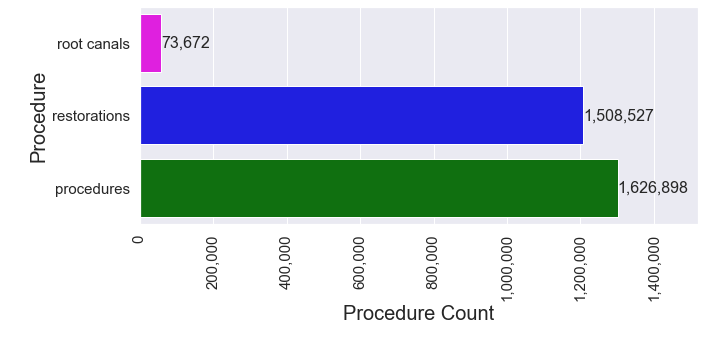

In [310]:
%matplotlib inline
sns.set()
colors = ['magenta', 'blue', 'green']
sns.set_palette(colors)

## plot gender counts
plt.figure(figsize=(10,4))
plt.ticklabel_format(style='plain', axis='x')
ax = sns.barplot(x=temp_df['total'], y=temp_df.index)

## set axis labels
ax.set_ylabel("\nProcedure", size=20)
ax.set_xlabel("Procedure Count\n", size=20)
plt.xticks(size=15)
plt.yticks(size=15)

## put commas in x-ticks
ax.set_xticklabels(['{:,}'.format(int(x)) for x in ax.get_xticks().tolist()])
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

## put numbers on each bar
show_values_on_bars(ax, h_v="h", horizontal_space=45, ha="left", va="center", fontsize=16)

## add extra room at the right of figure
ax.set_xlim(0, 1900000)

# plt.savefig("figures/tooth-procedure-counts.png", dpi=600, bbox_inches="tight")
plt.show()

#### count number of procs per tooth

In [179]:
tooth_proc_count_df = tooth_proc_df['tooth_num'].value_counts().sort_index().reset_index()
tooth_proc_count_df.columns = ['tooth_num', 'total']
tooth_proc_count_df.head()

,tooth_num,total
0,1,6579
1,2,87559
2,3,109808
3,4,65911
4,5,55809


#### count number of restoration and rct procs per tooth

In [187]:
study_procs_count_df = \
    tooth_proc_df[['tooth_num', 'restoration', 'rct']].groupby('tooth_num').sum().reset_index()
study_procs_count_df.head()

,tooth_num,restoration,rct
0,1,5779,59
1,2,82478,2375
2,3,102101,4778
3,4,59734,4230
4,5,51370,2912


#### merge proc counts into single dataframe

In [189]:
tooth_proc_count_df = pds.merge(tooth_proc_count_df, study_procs_count_df, on='tooth_num')
tooth_proc_count_df.head()

,tooth_num,total,restoration,rct
0,1,6579,5779,59
1,2,87559,82478,2375
2,3,109808,102101,4778
3,4,65911,59734,4230
4,5,55809,51370,2912


#### add percentage info

In [206]:
# calc percentages; note: variables determined above
tooth_proc_count_df['pct_total'] = (tooth_proc_count_df.total/proc_total) * 100
tooth_proc_count_df['pct_restoration'] = (tooth_proc_count_df.restoration/proc_total) * 100
tooth_proc_count_df['pct_rct'] = (tooth_proc_count_df.rct/proc_total) * 100

/var/folders/y_/64f732h167b9rmtn1k_dc8f00000gn/T/ipykernel_1401/596725638.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tooth_proc_count_df['pct_total'] = (tooth_proc_count_df.total/proc_total) * 100
/var/folders/y_/64f732h167b9rmtn1k_dc8f00000gn/T/ipykernel_1401/596725638.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tooth_proc_count_df['pct_restoration'] = (tooth_proc_count_df.restoration/proc_total) * 100
/var/folders/y_/64f732h167b9rmtn1k_dc8f00000gn/T/ipykernel_1401/596725638.py:4: SettingW

In [207]:
# round to single decimal
tooth_proc_count_df['pct_total'] = round(tooth_proc_count_df['pct_total'], 1)
tooth_proc_count_df['pct_restoration'] = round(tooth_proc_count_df['pct_restoration'], 1)
tooth_proc_count_df['pct_rct'] = round(tooth_proc_count_df['pct_rct'], 1)

/var/folders/y_/64f732h167b9rmtn1k_dc8f00000gn/T/ipykernel_1401/1249953043.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tooth_proc_count_df['pct_total'] = round(tooth_proc_count_df['pct_total'], 1)
/var/folders/y_/64f732h167b9rmtn1k_dc8f00000gn/T/ipykernel_1401/1249953043.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tooth_proc_count_df['pct_restoration'] = round(tooth_proc_count_df['pct_restoration'], 1)
/var/folders/y_/64f732h167b9rmtn1k_dc8f00000gn/T/ipykernel_1401/1249953043.py:4: SettingWi

In [208]:
# reorder columns
tooth_proc_count_df = \
    tooth_proc_count_df[['tooth_num', 'total', 'pct_total', 'restoration', 'pct_restoration', 'rct', 'pct_rct']]

In [376]:
# tooth_proc_count_df.to_clipboard()
tooth_proc_count_df.head()

,tooth_num,total,pct_total,restoration,pct_restoration,rct,pct_rct
0,1,6579,0.4,5779,0.4,59,0.0
1,2,87559,5.4,82478,5.1,2375,0.1
2,3,109808,6.7,102101,6.3,4778,0.3
3,4,65911,4.1,59734,3.7,4230,0.3
4,5,55809,3.4,51370,3.2,2912,0.2


## plot number of procedures on each tooth

/var/folders/y_/64f732h167b9rmtn1k_dc8f00000gn/T/ipykernel_1401/3195103383.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(), size=25)
/var/folders/y_/64f732h167b9rmtn1k_dc8f00000gn/T/ipykernel_1401/3195103383.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])


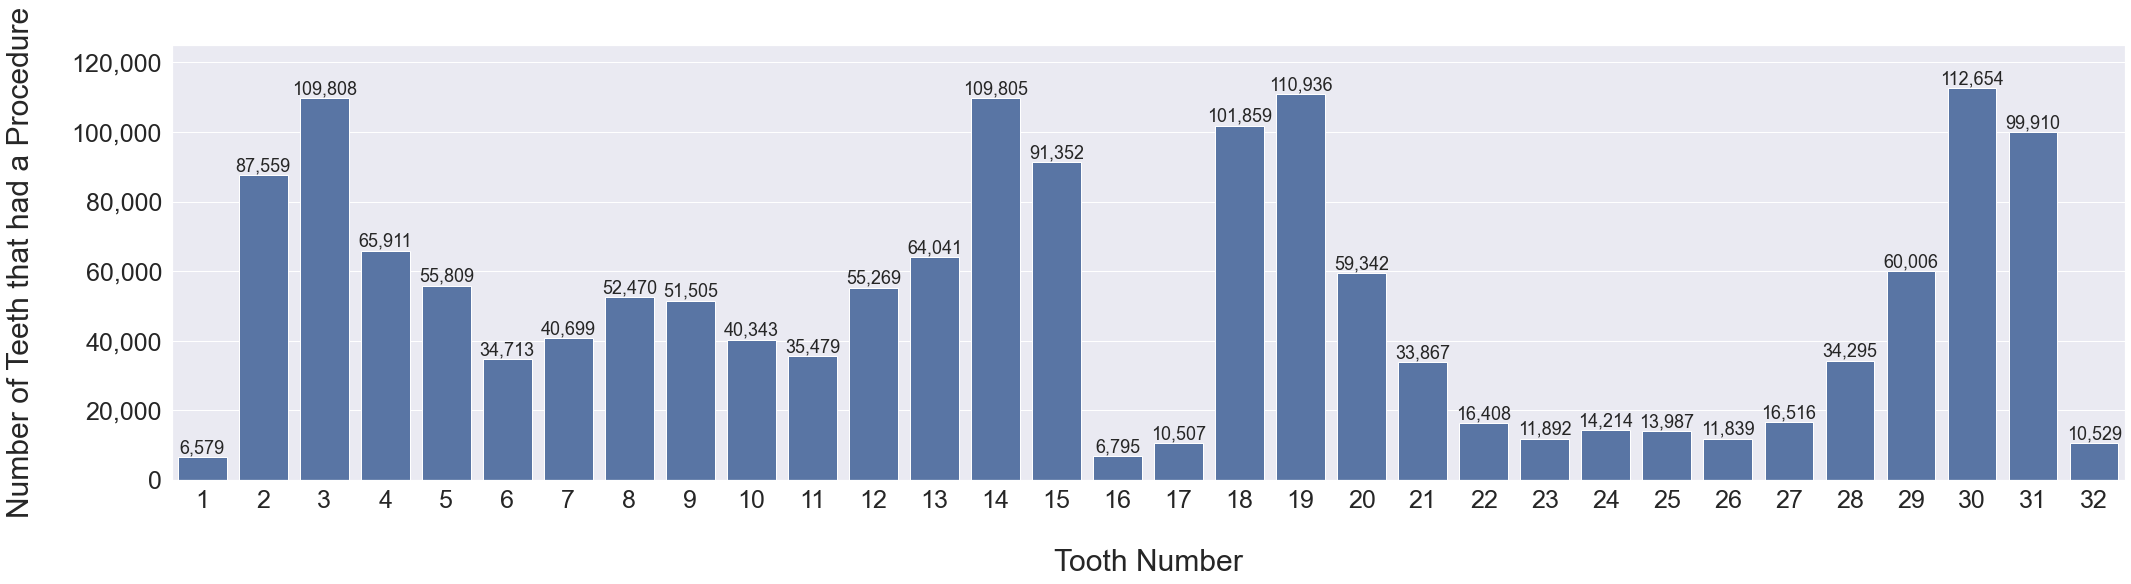

In [397]:
%matplotlib inline
sns.set()

plt.figure(figsize=(35,8))
ax = sns.barplot(x='tooth_num', y='total',data=tooth_proc_count_df, color='#4c72b0', dodge=True)

ax.set_xlabel("\nTooth Number", fontsize=30)
ax.set_ylabel("Number of Teeth that had a Procedure\n", fontsize=30)

tooth_nums = [x for x in range(1,33)] # create list of tooth nums
ax.set_xticklabels(tooth_nums, size=25)
ax.set_yticklabels(ax.get_yticks(), size=25)

# put commas in y-ticks
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])

## put numbers on each bar
show_values_on_bars(ax, h_v="v", vertical_space=100, fontsize=18)

## add extra room at top of figure
ax.set_ylim(0, 125000)

plt.savefig("figures/tooth-total-procedures-per-tooth.png", dpi=600, bbox_inches="tight")
plt.show()

## plot restoration and rct per tooth

/var/folders/y_/64f732h167b9rmtn1k_dc8f00000gn/T/ipykernel_1401/3782867288.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(), size=25)
/var/folders/y_/64f732h167b9rmtn1k_dc8f00000gn/T/ipykernel_1401/3782867288.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])


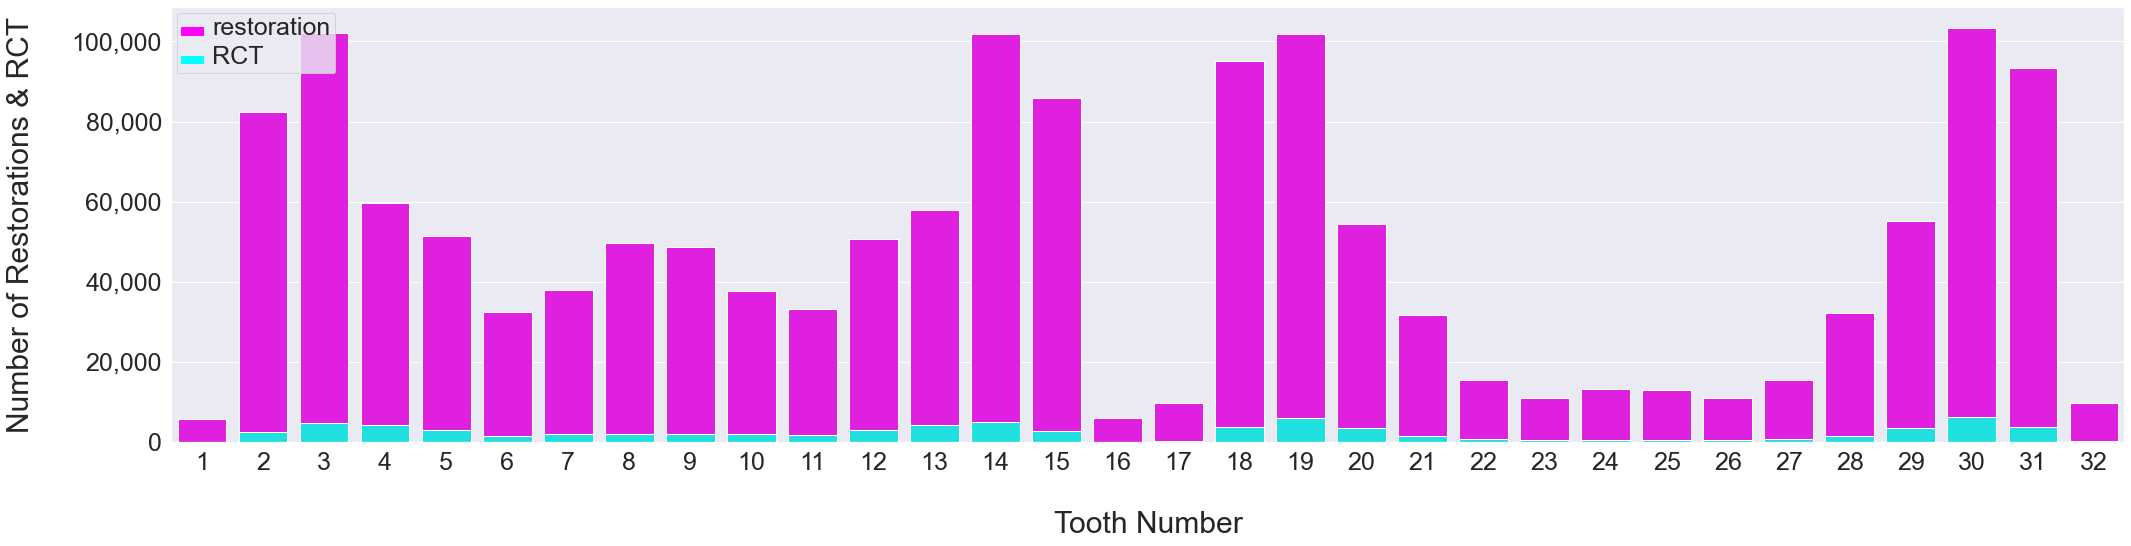

In [432]:
%matplotlib inline
sns.set()
colors = ['magenta', 'cyan']
sns.set_palette(colors)

plt.figure(figsize=(35,8))
ax = sns.barplot(x='tooth_num', y='restoration', data=tooth_proc_count_df, color='magenta')
ax = sns.barplot(x='tooth_num', y='rct', data=tooth_proc_count_df, color='cyan')

ax.set_xlabel("\nTooth Number", fontsize=30)
ax.set_ylabel("Number of Restorations & RCT\n", fontsize=30)

tooth_nums = [x for x in range(1,33)] # create list of tooth nums
ax.set_xticklabels(tooth_nums, size=25)
ax.set_yticklabels(ax.get_yticks(), size=25)

# put commas in y-ticks
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])

# add legend
top_bar = mpatches.Patch(color='magenta', label='restoration')
bottom_bar = mpatches.Patch(color='cyan', label='RCT')
plt.legend(handles=[top_bar, bottom_bar])
plt.setp(ax.get_legend().get_texts(), fontsize='25') #  legend text size

# plt.savefig("figures/tooth-total-restorations-rct-per-tooth.png", dpi=600, bbox_inches="tight")
plt.show()

## add tooth type data about whether the tooth underwent a restoration or rct

In [311]:
tooth_ids = tooth_type_df.tooth_id.values
restored_ids = np.array(restoration_df.tooth_id.unique())
rct_ids = np.array(rct_df.tooth_id.unique())

## temp values
temp_tooth_ids = tooth_type_df.head().tooth_id.values
temp_restored_ids = restored_ids[0:10]
# temp_tooth_ids

### keep track of tooth type length for sanity checking

In [366]:
tooth_type_count = len(tooth_type_df)
tooth_type_count

1194454

In [324]:
# tooth_proc_df.head()

### create temp dataframe of teeth have been restored

In [367]:
temp_restored_df = tooth_type_df[['tooth_id']]
temp_restored_df.insert(1, 'restored', 0) # add column of 0s

### set restored flag for tooth ids in restored tooth ids
**note**: check lengths for sanity check

In [368]:
temp_restored_df.restored = temp_restored_df.tooth_id.isin(restored_ids)
temp_restored_df.restored = temp_restored_df.restored.astype(int)
len(temp_restored_df) == tooth_type_count

/var/folders/y_/64f732h167b9rmtn1k_dc8f00000gn/T/ipykernel_1401/1914036036.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_restored_df.restored = temp_restored_df.tooth_id.isin(restored_ids)
/var/folders/y_/64f732h167b9rmtn1k_dc8f00000gn/T/ipykernel_1401/1914036036.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_restored_df.restored = temp_restored_df.restored.astype(int)


True

check if number of restored tooth ids match length of new dataframe

In [369]:
len(restored_ids) == len(temp_restored_df.query('restored == 1'))

True

### create temp dataframe of rct teeth

In [370]:
temp_rct_df = tooth_type_df[['tooth_id']]
temp_rct_df.insert(1, 'rct', 0) # add column of 0s

### set restored flag for tooth ids in rct tooth ids
**note**: check lengths for sanity check

In [371]:
temp_rct_df.rct = temp_rct_df.tooth_id.isin(rct_ids)
temp_rct_df.rct = temp_rct_df.rct.astype(int)
len(temp_rct_df) == tooth_type_count

/var/folders/y_/64f732h167b9rmtn1k_dc8f00000gn/T/ipykernel_1401/1246129446.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_rct_df.rct = temp_rct_df.tooth_id.isin(rct_ids)
/var/folders/y_/64f732h167b9rmtn1k_dc8f00000gn/T/ipykernel_1401/1246129446.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_rct_df.rct = temp_rct_df.rct.astype(int)


True

check if number of rct tooth ids match length of new dataframe

In [361]:
len(rct_ids) == len(temp_rct_df.query('rct == 1'))

True

### merge temp dataframes with tooth type info

In [373]:
tooth_type_df = \
    pds.merge(pds.merge(tooth_type_df, temp_restored_df, on='tooth_id'), temp_rct_df, on='tooth_id')
len(tooth_type_df) == tooth_type_count

True

In [574]:
# tooth_type_df.head()

In [447]:
tooth_type_count_df = pds.DataFrame(tooth_type_df.tooth_num.value_counts().sort_index()).reset_index()
tooth_type_count_df.rename(columns={'index':'tooth_num', 'tooth_num':'total'}, inplace=True)
tooth_type_count_df.head()

,tooth_num,total
0,1,5287
1,2,67372
2,3,81204
3,4,49527
4,5,42309


### plot number of each unique tooth types

/var/folders/y_/64f732h167b9rmtn1k_dc8f00000gn/T/ipykernel_1401/644382986.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(), size=25)
/var/folders/y_/64f732h167b9rmtn1k_dc8f00000gn/T/ipykernel_1401/644382986.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])


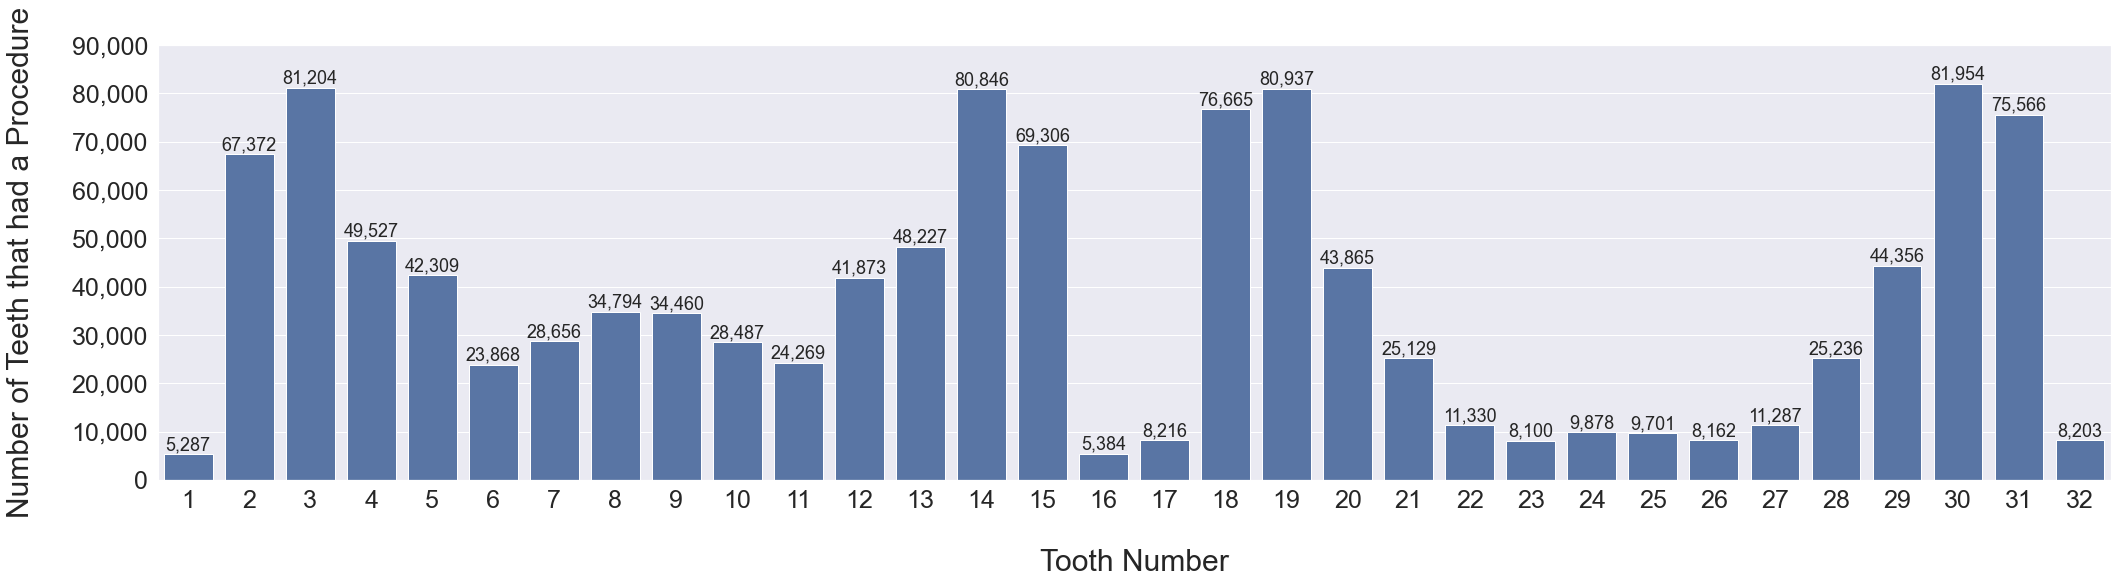

In [450]:
%matplotlib inline
sns.set()

plt.figure(figsize=(35,8))
ax = sns.barplot(x='tooth_num', y='total',data=tooth_type_count_df, color='#4c72b0', dodge=True)

ax.set_xlabel("\nTooth Number", fontsize=30)
ax.set_ylabel("Number of Teeth that had a Procedure\n", fontsize=30)

tooth_nums = [x for x in range(1,33)] # create list of tooth nums
ax.set_xticklabels(tooth_nums, size=25)
ax.set_yticklabels(ax.get_yticks(), size=25)

# put commas in y-ticks
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])

## put numbers on each bar
show_values_on_bars(ax, h_v="v", vertical_space=100, fontsize=18)

## add extra room at top of figure
ax.set_ylim(0, 90000)

# plt.savefig("figures/tooth-total-procedures-per-tooth.png", dpi=600, bbox_inches="tight")
plt.show()

## plot total number of distinct teeth by tooth type that underwent a procedure by gender

### join tooth type information to gender information

In [538]:
tooth_gender_df = pds.merge(tooth_type_df, patient_df[['patient_id', 'gender']], on='patient_id', how='left')
len(tooth_gender_df) == len(tooth_type_df)

True

### get counts for tooth_num and gender

In [537]:
tooth_gender_count_df = pds.DataFrame(tooth_gender_df.groupby(['tooth_num', 'gender'])['gender'].count())
tooth_gender_count_df.columns = ['total']
tooth_gender_count_df.reset_index(inplace=True)
tooth_gender_count_df.head()

,tooth_num,gender,total
0,1,female,2420
1,1,male,2867
2,2,female,37818
3,2,male,29554
4,3,female,45961


### plot tooth types for each gender

/var/folders/y_/64f732h167b9rmtn1k_dc8f00000gn/T/ipykernel_1401/2829830330.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(), size=13)
/var/folders/y_/64f732h167b9rmtn1k_dc8f00000gn/T/ipykernel_1401/2829830330.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()]) # put commas in y-ticks


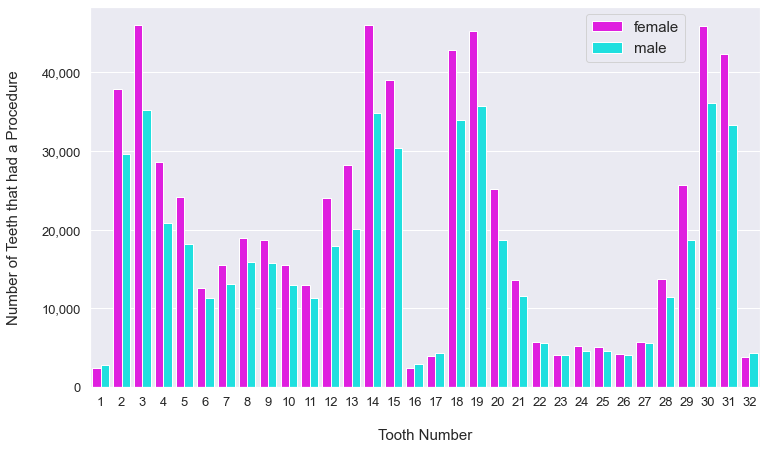

In [540]:
%matplotlib inline
sns.set()
colors = ['magenta', 'cyan']
sns.set_palette(colors)

plt.figure(figsize=(12,7))
ax = sns.barplot(x='tooth_num', y='total', hue='gender',data=tooth_gender_count_df)

ax.set_xlabel("\nTooth Number", fontsize=15)
ax.set_ylabel("Number of Teeth that had a Procedure\n", fontsize=15)

tooth_nums = [x for x in range(1,33)] # create list of tooth nums
ax.set_xticklabels(tooth_nums, size=13)
ax.set_yticklabels(ax.get_yticks(), size=13)
ax.legend(loc='upper right', fontsize=15, bbox_to_anchor=(0.9, 1))

ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()]) # put commas in y-ticks
# plt.savefig("figures/tooth-count-per-tooth-by-gender.png", dpi=600, bbox_inches="tight")
plt.show()

## create table with tooth number totals for females, males, and all teeth

get group counts for tooth and gender

In [576]:
gender_group = tooth_gender_df.groupby(['tooth_num', 'gender'])['gender'].count()
gender_group

tooth_num  gender
1          female     2420
           male       2867
2          female    37818
           male      29554
3          female    45961
                     ...  
30         male      36133
31         female    42233
           male      33333
32         female     3853
           male       4350
Name: gender, Length: 64, dtype: int64

unstack the group to get a dataframe

In [584]:
gender_count_table = gender_group.unstack()
gender_count_table.columns.name = '' # remove 'gender' group name for female and male columns
gender_count_table.reset_index(inplace=True)
gender_count_table.head()

,tooth_num,female,male
0,1,2420,2867
1,2,37818,29554
2,3,45961,35243
3,4,28641,20886
4,5,24148,18161


merge gender totals with column that all totals for each tooth

In [587]:
all_tooth_count_table = \
    pds.merge(gender_count_table, tooth_type_count_df, how='inner', on='tooth_num').rename(columns={'num_teeth': 'total'})

In [588]:
all_tooth_count_table.head()

,tooth_num,female,male,total
0,1,2420,2867,5287
1,2,37818,29554,67372
2,3,45961,35243,81204
3,4,28641,20886,49527
4,5,24148,18161,42309


## summarize number of surfaces restored

In [573]:
# proc_surface_df.head()

In [543]:
surface_proc_count_query = """
select 
    sum(m) as M,
    sum(o) as O,
    sum(d) as D,
    sum(b) as B,
    sum(f) as F,
    sum(l) as L,
    sum(i) as I
from
    proc_surface_df
"""
surface_proc_count_df = sqldf(surface_proc_count_query)

In [544]:
surface_proc_count_df

,M,O,D,B,F,L,I
0,349287,828423,379686,89869,293902,288136,34517


### melt dataframe for plotting

In [545]:
surface_melt_df = pds.melt(surface_proc_count_df, value_vars=['M', 'O', 'D', 'B', 'F', 'L', 'I'], var_name='surface', value_name='total')

In [546]:
surface_melt_df

,surface,total
0,M,349287
1,O,828423
2,D,379686
3,B,89869
4,F,293902
5,L,288136
6,I,34517


### plot

/var/folders/y_/64f732h167b9rmtn1k_dc8f00000gn/T/ipykernel_1401/3383926710.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_yticks(), size=14)
No handles with labels found to put in legend.
/var/folders/y_/64f732h167b9rmtn1k_dc8f00000gn/T/ipykernel_1401/3383926710.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:,}'.format(int(x)) for x in ax.get_xticks().tolist()]) # put commas in x-ticks


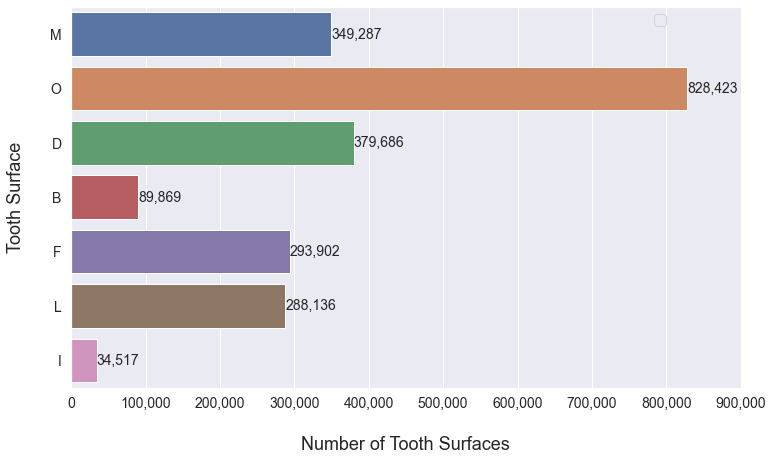

In [547]:
%matplotlib inline
sns.set()

plt.figure(figsize=(12,7))
ax = sns.barplot(x='total', y='surface', data=surface_melt_df)

ax.set_xlabel("\nNumber of Tooth Surfaces", fontsize=18)
ax.set_ylabel("Tooth Surface\n", fontsize=18)

y_ticks = ['M', 'O', 'D', 'B', 'F', 'L', 'I']
ax.set_xticklabels(ax.get_yticks(), size=14)
ax.set_yticklabels(y_ticks, size=14)

ax.legend(loc='upper right', fontsize=15, bbox_to_anchor=(0.9, 1))

ax.set_xticklabels(['{:,}'.format(int(x)) for x in ax.get_xticks().tolist()]) # put commas in x-ticks

## put numbers on each bar
show_values_on_bars(ax, h_v="h", horizontal_space=30, ha="left", va="center", fontsize=14)

## add extra room for numbers
ax.set_xlim(0, 900000)

plt.savefig("figures/surfaces-restored-count.png", dpi=600, bbox_inches="tight")
plt.show()

## summarize number of surfaces restored for each tooth type

In [548]:
tooth_surface_proc_count_query = """
select
    case 
        when incisor = 1 then 'incisor'
        when canine = 1 then 'canine'
        when premolar = 1 then 'premolar'
        when molar = 1 then 'molar'
    end as tooth_type,
    case 
        when num_surfaces = 1 then '1 surface'
        when num_surfaces = 2 then '2 surfaces'
        when num_surfaces > 2 then '3+ surfaces'
    end as surface_category,
    count(*) as total
from 
    proc_surface_df
inner join
    tooth_type_df
on 
    proc_surface_df.tooth_id = tooth_type_df.tooth_id
where 
    num_surfaces > 0
group by 
    tooth_type, surface_category
order by
    surface_category, tooth_type
"""
tooth_surface_proc_count_df = sqldf(tooth_surface_proc_count_query)

In [549]:
tooth_surface_proc_count_df

,tooth_type,surface_category,total
0,canine,1 surface,39039
1,incisor,1 surface,65656
2,molar,1 surface,305022
3,premolar,1 surface,112547
4,canine,2 surfaces,25324
5,incisor,2 surfaces,60660
6,molar,2 surfaces,242478
7,premolar,2 surfaces,140076
8,canine,3+ surfaces,15874
9,incisor,3+ surfaces,62067


### plot

/var/folders/y_/64f732h167b9rmtn1k_dc8f00000gn/T/ipykernel_1401/1789550321.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(), size=13)
/var/folders/y_/64f732h167b9rmtn1k_dc8f00000gn/T/ipykernel_1401/1789550321.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()]) # put commas in y-ticks


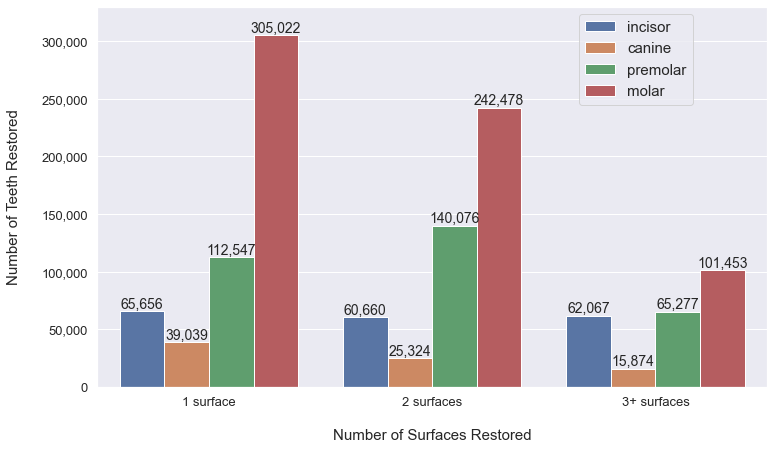

In [550]:
%matplotlib inline
sns.set()

plt.figure(figsize=(12,7))
ax = sns.barplot(x='surface_category', y='total', data=tooth_surface_proc_count_df,
                 hue="tooth_type", hue_order=['incisor', 'canine', 'premolar', 'molar'])

ax.set_xlabel("\nNumber of Surfaces Restored", fontsize=15)
ax.set_ylabel("Number of Teeth Restored\n", fontsize=15)

x_ticks = ['1 surface', '2 surfaces', '3+ surfaces']
ax.set_xticklabels(x_ticks, size=13)
ax.set_yticklabels(ax.get_yticks(), size=13)

ax.legend(loc='upper right', fontsize=15, bbox_to_anchor=(0.9, 1))

ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()]) # put commas in y-ticks

## put numbers on each bar
show_values_on_bars(ax, h_v="v", vertical_space=100, fontsize=14)

## add extra room at top of figure
ax.set_ylim(0, 330000)

plt.savefig("figures/surfaces-restored-by-tooth-type-count.png", dpi=600, bbox_inches="tight")
plt.show()

## summarize materials used for tooth type

### create a column with three general categories of materials: ceramic, metal, resin

In [551]:
def get_material_category(material):
    if pds.isnull(material): return material
    
    if material in ['ceramic', 'porcelain']:
        return 'ceramic'
    elif material in ['metal', 'predominantly base metal', 'stainless steel', 'noble metal', 'high noble metal', 'amalgam', 'gold foil']:
        return 'metal'
    elif material in ['resin']:
        return 'resin'
    else:
        return None

In [552]:
proc_material_df['material_category'] = proc_material_df['material'].map(lambda x: get_material_category(x))

In [553]:
# proc_material_df.head()

### build data frame of each the material used in each tooth
### note: use dropna to remove procedures with no materials

In [554]:
tooth_material_proc_df = \
    pds.merge(proc_material_df.dropna(), 
              tooth_type_df[['tooth_id','anterior','posterior','incisor','canine','premolar','molar','maxillary','mandibular','left','right']], 
              how='inner', 
              on='tooth_id')

In [555]:
# tooth_material_proc_df.head()

In [556]:
tooth_material_proc_count_df = \
    tooth_material_proc_df[['material_category','incisor','canine','premolar','molar']].groupby('material_category').sum()
tooth_material_proc_count_df.reset_index(inplace=True)

In [557]:
 tooth_material_proc_count_df

,material_category,incisor,canine,premolar,molar
0,ceramic,30916,13267,67849,126982
1,metal,18299,11171,86910,214456
2,resin,187773,78645,283226,546268


### melt dataframe for plotting

In [558]:
tooth_material_proc_count_melt_df = \
    tooth_material_proc_count_df.melt(id_vars=['material_category'], var_name='tooth_type', 
                                      value_vars=['incisor', 'canine', 'premolar', 'molar'], value_name='total')

In [559]:
tooth_material_proc_count_melt_df

,material_category,tooth_type,total
0,ceramic,incisor,30916
1,metal,incisor,18299
2,resin,incisor,187773
3,ceramic,canine,13267
4,metal,canine,11171
5,resin,canine,78645
6,ceramic,premolar,67849
7,metal,premolar,86910
8,resin,premolar,283226
9,ceramic,molar,126982


### plot

/var/folders/y_/64f732h167b9rmtn1k_dc8f00000gn/T/ipykernel_1401/874321747.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(), size=15)
/var/folders/y_/64f732h167b9rmtn1k_dc8f00000gn/T/ipykernel_1401/874321747.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()]) # put commas in y-ticks


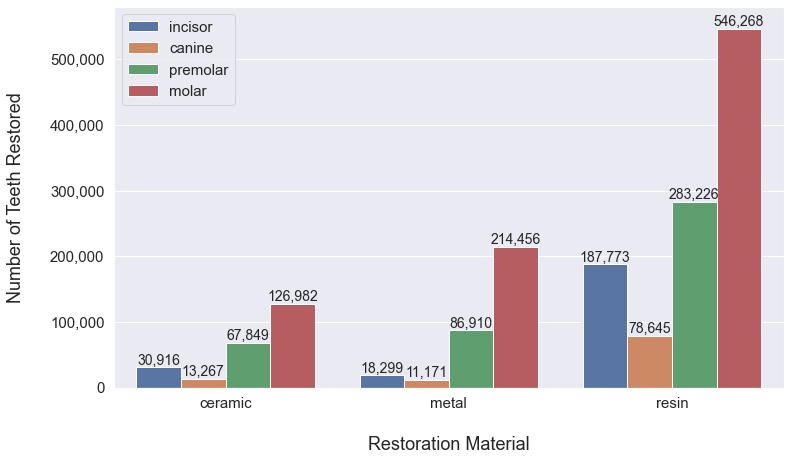

In [560]:
%matplotlib inline
sns.set()

plt.figure(figsize=(12,7))
ax = sns.barplot(x='material_category', y='total', data=tooth_material_proc_count_melt_df, hue='tooth_type')

ax.set_xlabel("\nRestoration Material", fontsize=18)
ax.set_ylabel("Number of Teeth Restored\n", fontsize=18)

x_ticks = ['ceramic', 'metal', 'resin']
ax.set_xticklabels(x_ticks, size=15)
ax.set_yticklabels(ax.get_yticks(), size=15)

ax.legend(loc='upper left', fontsize=15)

ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()]) # put commas in y-ticks

## put numbers on each bar
show_values_on_bars(ax, h_v="v", vertical_space=100, fontsize=14)

## add extra room at top of figure
ax.set_ylim(0, 580000)

plt.savefig("figures/restoration-materials-per-tooth-count.png", dpi=600, bbox_inches="tight")
plt.show()

## plot material use over time

### add procedure dates to the tooth/materal dataframe

In [561]:
tooth_material_proc_date_df = \
    pds.merge(tooth_material_proc_df, tooth_proc_df[['proc_id', 'event_date']], how='inner', on='proc_id')
tooth_material_proc_date_df.event_date = pds.to_datetime(tooth_material_proc_date_df.event_date)
tooth_material_proc_date_df['event_year'] = pds.DatetimeIndex(tooth_material_proc_date_df.event_date).year

### drop any years > 2015

In [562]:
tooth_material_proc_date_df = tooth_material_proc_date_df[tooth_material_proc_date_df.event_year < 2016]

In [563]:
material_proc_date_count_df = \
    pds.DataFrame(tooth_material_proc_date_df.groupby(['event_year', 'material_category'])['material_category']\
                  .count())\
                  .rename(columns={'material_category': 'total'})\
                  .reset_index()

In [564]:
material_proc_date_count_df[material_proc_date_count_df.event_year > 2013]

,event_year,material_category,total
98,2014,ceramic,15266
99,2014,metal,12238
100,2014,resin,85261
101,2015,ceramic,13870
102,2015,metal,9641
103,2015,resin,75311


### plot

/var/folders/y_/64f732h167b9rmtn1k_dc8f00000gn/T/ipykernel_1401/1300804759.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])


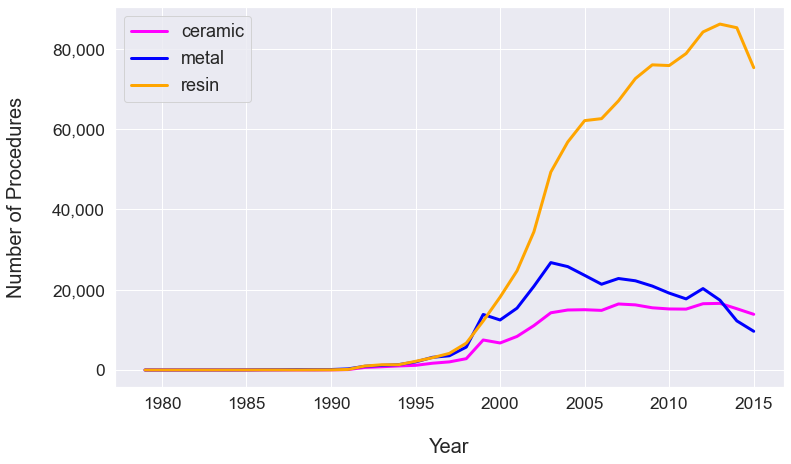

In [565]:
%matplotlib inline
sns.set()
sns.set_context(rc={"lines.linewidth": 3})
colors = ['magenta', 'blue', 'orange']
sns.set_palette(colors)

plt.figure(figsize=(12,7))
ax = sns.lineplot(x="event_year", y="total", data=material_proc_date_count_df, hue="material_category", legend=False)

ax.set_xlabel("\nYear", fontsize=20)
ax.set_ylabel("Number of Procedures\n", fontsize=20)

ax.tick_params(labelsize='x-large') # use large labels
plt.xticks(rotation=0)  # rotate the ticks on the x axis

## put commas in y-ticks
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])

plt.legend(loc='upper left', labels=['ceramic', 'metal', 'resin'], prop={'size': 18})
plt.savefig("figures/materials-used-by-year-line.png", dpi=600, bbox_inches="tight")
plt.show()

### plot tooth by matial use over time

In [566]:
# tooth_material_proc_date_df.head()

In [567]:
tooth_material_over_time_count_df = \
    pds.DataFrame(tooth_material_proc_date_df[['material_category', 'event_year', 'anterior', 'posterior']]\
                  .groupby(['event_year','material_category'])
                  .sum())\
                  .reset_index()

In [568]:
# tooth_material_over_time_count_df.head()

In [569]:
tooth_material_over_time_count_df[tooth_material_over_time_count_df.event_year > 2013]

,event_year,material_category,anterior,posterior
98,2014,ceramic,2753,12513
99,2014,metal,1181,11057
100,2014,resin,18068,67193
101,2015,ceramic,2320,11550
102,2015,metal,901,8740
103,2015,resin,16839,58472


### melt dataframe for plotting

In [570]:
tooth_material_over_time_count_melt_df = \
    tooth_material_over_time_count_df.melt(id_vars=['material_category', 'event_year'], var_name='tooth_type', 
                                           value_vars=['anterior', 'posterior'], value_name='total')

In [571]:
tooth_material_over_time_count_melt_df[tooth_material_over_time_count_melt_df.event_year > 2013]

,material_category,event_year,tooth_type,total
98,ceramic,2014,anterior,2753
99,metal,2014,anterior,1181
100,resin,2014,anterior,18068
101,ceramic,2015,anterior,2320
102,metal,2015,anterior,901
103,resin,2015,anterior,16839
202,ceramic,2014,posterior,12513
203,metal,2014,posterior,11057
204,resin,2014,posterior,67193
205,ceramic,2015,posterior,11550


### plot

/var/folders/y_/64f732h167b9rmtn1k_dc8f00000gn/T/ipykernel_1401/1941184820.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.axes[0,0].set_xticklabels(g.axes[0,0].get_xticklabels(), size=20)
/var/folders/y_/64f732h167b9rmtn1k_dc8f00000gn/T/ipykernel_1401/1941184820.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.axes[0,1].set_xticklabels(g.axes[0,1].get_xticklabels(), size=20)
/var/folders/y_/64f732h167b9rmtn1k_dc8f00000gn/T/ipykernel_1401/1941184820.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.axes[0,0].set_yticklabels(g.axes[0,0].get_yticklabels(), size=20)
/var/folders/y_/64f732h167b9rmtn1k_dc8f00000gn/T/ipykernel_1401/1941184820.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.axes[0,0].set_yticklabels(['{:,}'.format(int(x)) for x in g.axes[0,0].get_yticks().tolist()])


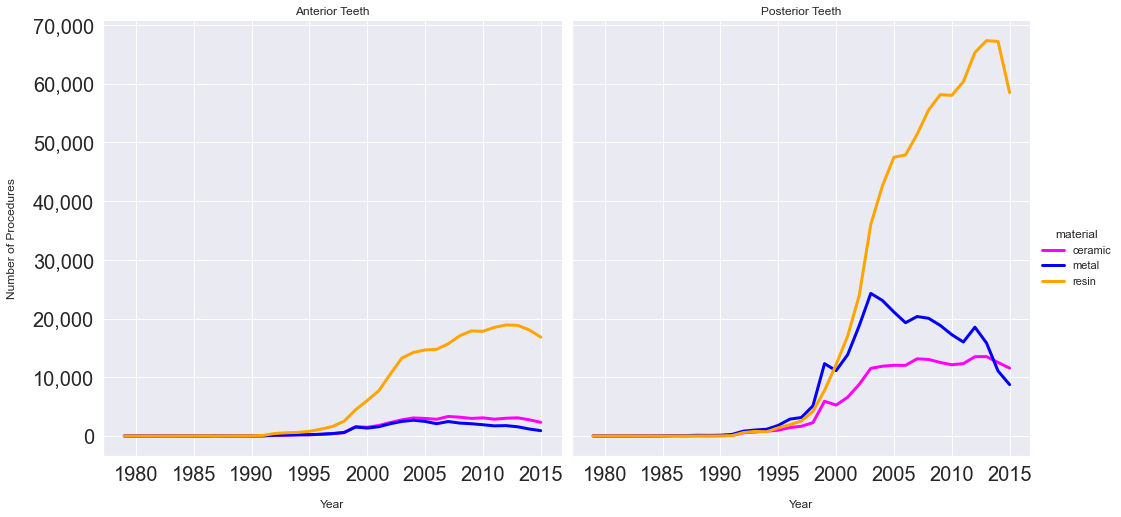

In [572]:
%matplotlib inline
sns.set_context(rc={"lines.linewidth": 3})
colors = ['magenta', 'blue', 'orange']
sns.set_palette(colors)

g = sns.FacetGrid(tooth_material_over_time_count_melt_df, col='tooth_type', hue='material_category', height=7)
g = g.map(sns.lineplot, 'event_year', 'total', ci=None).add_legend(title="material")

## set x and y labels
g.axes[0,0].set_xlabel('\nYear')
g.axes[0,1].set_xlabel('\nYear')
g.axes[0,0].set_ylabel('Number of Procedures\n')

## set title for left and right
g.axes[0,0].set_title('Anterior Teeth')
g.axes[0,1].set_title('Posterior Teeth')


## set size of xticks
g.axes[0,0].set_xticklabels(g.axes[0,0].get_xticklabels(), size=20)
g.axes[0,1].set_xticklabels(g.axes[0,1].get_xticklabels(), size=20)

## set size of y ticks and add commas to numbers
g.axes[0,0].set_yticklabels(g.axes[0,0].get_yticklabels(), size=20)
g.axes[0,0].set_yticklabels(['{:,}'.format(int(x)) for x in g.axes[0,0].get_yticks().tolist()])

plt.savefig("figures/tooth-and-materials-used-by-year-line.png", dpi=600, bbox_inches="tight")
plt.show()